Implementation of Image Style Transfer with Convolutional Neural Networks (https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

Using Pre-Trained VGG19 Model

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import time

### Hyperparameters

In [0]:
dir_loc = '/content/drive/My Drive/Colab Notebooks/Neural_Style_Transfer/'
IMAGE_SIZE = 256

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.35,
                 'conv4_1': 0.25,
                 'conv5_1': 0.40
                }
content_weight = 1  # alpha
style_weight = 1e6  # beta


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
style_image = Image.open(dir_loc + 'style_images/starry_night.jpg')
style_image_test = style_image.resize((IMAGE_SIZE,IMAGE_SIZE))
style_image_arr = np.array(style_image_test)

content_image = Image.open(dir_loc + 'content_images/seattle.jpg')
content_image_test = content_image.resize((IMAGE_SIZE,IMAGE_SIZE))
content_image_arr = np.array(content_image_test)

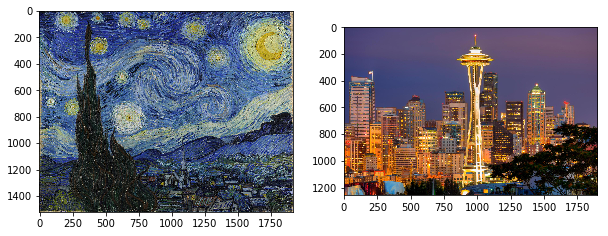

In [72]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(style_image)
axes[1].imshow(content_image)

In [73]:
inputs = [content_image, style_image]
def get_image_info(images):
  info = {
      'content' : None,
      'style' : None
  }
  for idx,im in enumerate(images):
    im = np.array(im)
    means,stds = cv2.meanStdDev(im)
    if idx == 0:
      info['content'] = (means,stds)
    elif idx == 1:
      info['style'] = (means,stds) 
  return info

img_info = get_image_info(inputs)
print(img_info)

{'content': (array([[102.98716274],
       [ 79.73234647],
       [ 82.41332762]]), array([[59.39685899],
       [42.36392646],
       [47.56333539]])), 'style': (array([[ 76.77738063],
       [ 92.40165074],
       [110.72772791]]), array([[50.43975589],
       [52.49459282],
       [55.1217229 ]]))}


In [0]:
content_transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(tuple(img_info['content'][0]),tuple(img_info['content'][1]))
])

style_transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(tuple(img_info['style'][0]),tuple(img_info['style'][1]))
])

gen_transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [0]:
# Convert to torch tensors
# style_image = torch.from_numpy(style_image)
# style_image = style_image.type(torch.FloatTensor)

# content_image = torch.from_numpy(content_image)
# content_image = content_image.type(torch.FloatTensor)

content = gen_transformer(content_image).to(device)
style = gen_transformer(style_image).to(device)

In [0]:
output = content.clone()
output.requires_grad = True
output = output.to(device)

In [77]:
# Getting the Pre-trained VGG19 Model except for fc layers
vgg19 = torchvision.models.vgg19(pretrained=True).features
vgg19.to(device)
print(vgg19)
print()
print(vgg19._modules.items())

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def get_features(image,model):
  """Feature Retreival from forward
  pass"""
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2',
      '28': 'conv5_1'
  }
  
  features = {}
  x = image
  x = torch.unsqueeze(x,0)
  for name,layer in model._modules.items():
    x = layer(x)
    if(name in layers):
      features[layers[name]] = x
  return features

def gram_matrix(tensor):
  """Generate Gram Matrix"""
  _,d,h,w = tensor.size()
  tensor = tensor.view(d,h*w)
  gram = torch.matmul(tensor,tensor.t())
  return gram

def unnorm_img(tensor):
  """tensor to image"""
  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0,1)
  return image

In [0]:
# Get "Ground Truth" Features from Original Image
gt_content_features = get_features(content, vgg19)
gt_style_features = get_features(style, vgg19)

style_grams = {layer: gram_matrix(gt_style_features[layer]) for layer in gt_style_features}

Total Loss: 171641904.0, Content Loss: 0.0, Style Loss: 171.64190673828125


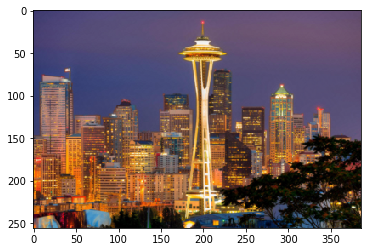

Total Loss: 6910464.5, Content Loss: 11.17502498626709, Style Loss: 6.9104533195495605


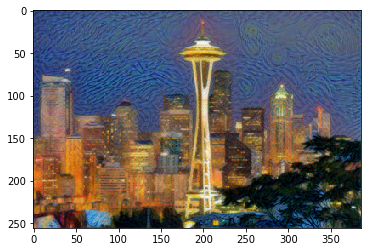

Total Loss: 3044200.25, Content Loss: 12.291877746582031, Style Loss: 3.0441880226135254


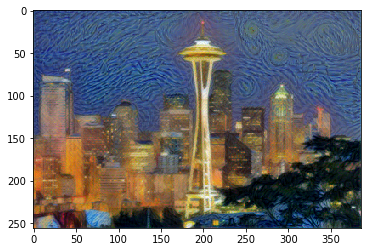

Total Loss: 1837874.0, Content Loss: 12.855657577514648, Style Loss: 1.837861180305481


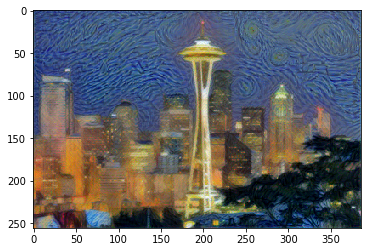

Total Loss: 1250464.0, Content Loss: 13.227170944213867, Style Loss: 1.2504507303237915


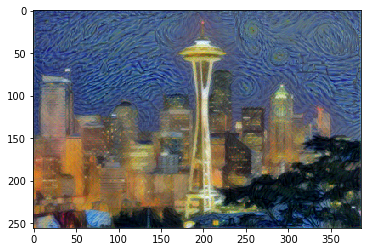

Total Loss: 914009.0, Content Loss: 13.516520500183105, Style Loss: 0.9139955043792725


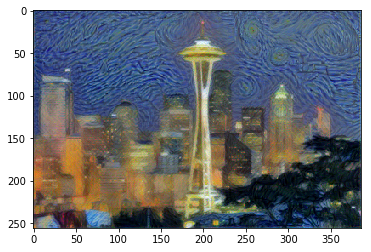

Total Loss: 703096.4375, Content Loss: 13.727773666381836, Style Loss: 0.7030826807022095


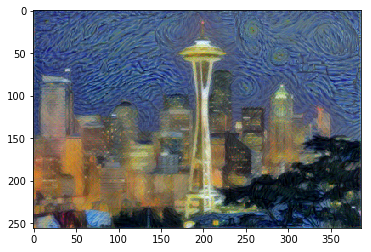

Total Loss: 563211.75, Content Loss: 13.892463684082031, Style Loss: 0.5631978511810303


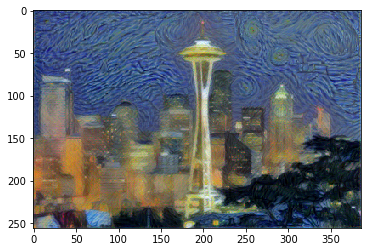

Total Loss: 466312.375, Content Loss: 14.017549514770508, Style Loss: 0.46629834175109863


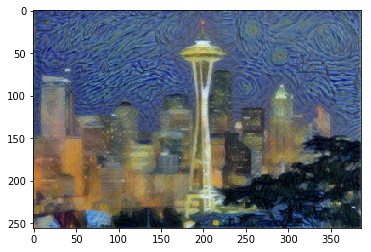

Total Loss: 396849.8125, Content Loss: 14.120646476745605, Style Loss: 0.39683568477630615


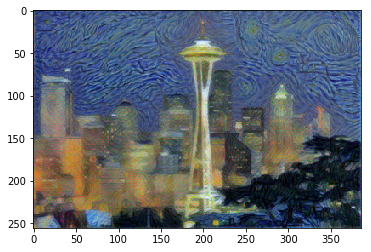

Total Loss: 345651.65625, Content Loss: 14.203256607055664, Style Loss: 0.3456374406814575


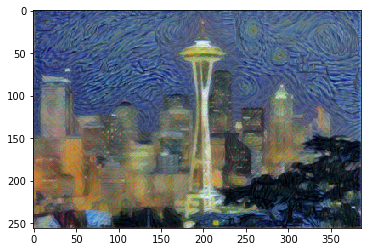

Total Loss: 307041.6875, Content Loss: 14.2691068649292, Style Loss: 0.3070273995399475


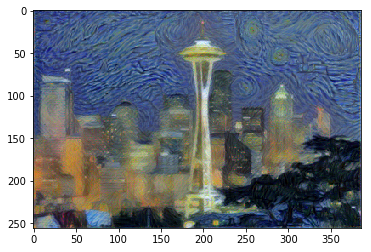

Total Loss: 277143.03125, Content Loss: 14.332308769226074, Style Loss: 0.2771286964416504


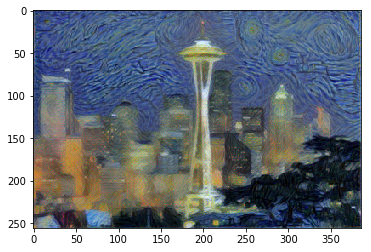

Total Loss: 253362.828125, Content Loss: 14.388266563415527, Style Loss: 0.2533484399318695


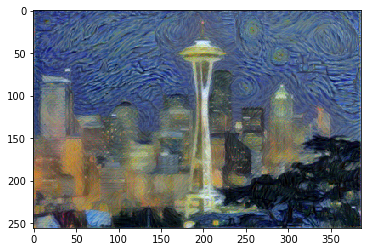

Total Loss: 234257.421875, Content Loss: 14.436927795410156, Style Loss: 0.2342429906129837


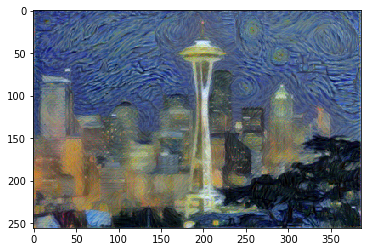

Total Loss: 218615.90625, Content Loss: 14.485106468200684, Style Loss: 0.21860142052173615


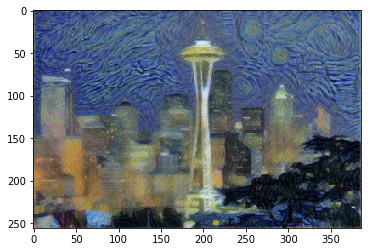

Total Loss: 205588.671875, Content Loss: 14.530521392822266, Style Loss: 0.2055741399526596


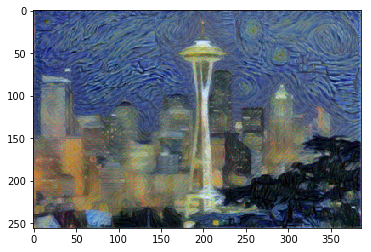

Total Loss: 194590.640625, Content Loss: 14.570304870605469, Style Loss: 0.19457608461380005


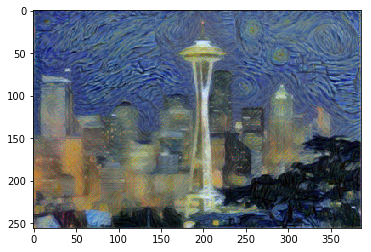

Total Loss: 185181.421875, Content Loss: 14.607086181640625, Style Loss: 0.18516680598258972


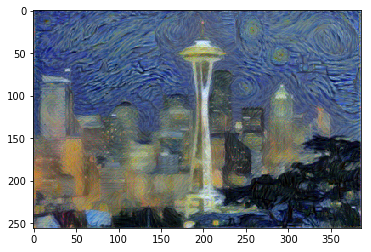

Total Loss: 177098.21875, Content Loss: 14.643241882324219, Style Loss: 0.1770835816860199


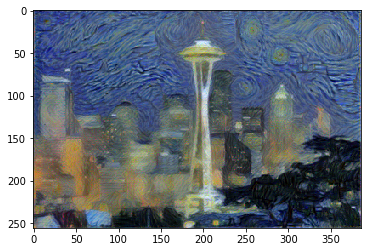

In [80]:
optimizer = torch.optim.Adam([output],lr=0.01)
steps = 2000

for step in range(steps):
  
  output_features = get_features(output,vgg19)
  
  # -- Calculate Content Loss --
  content_loss = torch.mean((output_features['conv4_2'] - gt_content_features['conv4_2'])**2)
  
  # -- Calculate Style Loss --
  style_loss = 0 # init style loss
  for layer in style_weights:
    output_feature = output_features[layer]
    output_gram = gram_matrix(output_feature)
    _,d,h,w = output_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((output_gram - style_gram)**2)
    style_loss += layer_style_loss/(d*h*w)
  
  # -- Calculate Total Loss --
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  # Update Output Image
  optimizer.zero_grad()
  total_loss.backward(retain_graph=True)
  optimizer.step()
  
  if(step % 100 == 0):
    print('Total Loss: {}, Content Loss: {}, Style Loss: {}'.format(total_loss,content_loss,style_loss))
    plt.imshow(unnorm_img(output))
    plt.show()

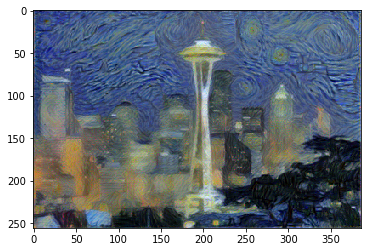

In [81]:
plt.imshow(unnorm_img(output))

In [0]:
def get_current_time():
    '''
    Using time module to get current time and using it 
    as a time convention.
    '''
    minute = time.localtime().tm_min
    hour = time.localtime().tm_hour
    day = time.localtime().tm_mday
    month = time.localtime().tm_mon
    year = time.localtime().tm_year
    return minute, hour, day, month, year

minute, hour, day, month, year = get_current_time()
plt.imsave(dir_loc+'output_images/'+str(year)+'_'+str(month)+'_'+str(day)+'_'+str(hour)+'_'+str(minute),unnorm_img(output))